![](pngs/nba_ml.png)
1. Define Foundation
2. Get Data from MongoDB Cloud and create 'champ_data.csv'
3. Analyze Champion Data 
<br> - Results ...
4. Machine Learning Process 
5. PowerBi Charts
---

### ➤ 1 Define Foundation 

In [7]:
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymongo
import seaborn as sns
import shap
from pandas import json_normalize
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             ndcg_score, r2_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor

In [12]:
MAX_SEASON = 2022
LAST_N_SEASONS = 3
RANDOM_SEED = 12345
random.seed(RANDOM_SEED)

DB_NAME = "NBA"
COLLECTION_PLAYER = "player"
COLLECTION_TEAM = "team"
URI = "mongodb://localhost:27017"

In [13]:
def convert_to_percent(cell_value: str):
    if cell_value is None or cell_value is np.nan or cell_value == 'nan':
        return None 
    if cell_value == "0-0":
        return 0
    
    splits = cell_value.split("-")
    splits = [int(i) for i in splits]
    
    if sum(splits) == 0: return 0
    
    if len(splits) == 2:    
        return splits[0] / sum(splits)
    
    numerator = 0
    for i in range(0, len(splits)):
        if i % 2 == 0:
            numerator += splits[i]
            
    return numerator / sum(splits)

In [14]:
class MongoDBAgent:
    name = "MongoDBAgent"

    def __init__(self, con_string: str, db: str):
        self.__client = pymongo.MongoClient(con_string)
        self.__db = self.__client[db]
        self.__connect_db()


    def __connect_db(self):
        self.__client.server_info()


    def find(self, collection_str: str, query: dict, count=False):
        collection = self.__db[collection_str]
        documents = collection.find(query)
        if count: return collection.count_documents(query)
        if collection.count_documents(query) == 0: return None
        return documents

In [15]:
MONGODB_AGENT = MongoDBAgent(con_string=URI, db=DB_NAME)  

### ➤ 2 Get Data from MongoDB Cloud and create 'champ_data.csv' 

In [16]:
documents = MONGODB_AGENT.find(collection_str=COLLECTION_TEAM, query={}, count=False)
df = json_normalize(list(documents))
df.drop(['_id', 'lg', 'per_game-team.G', 'per_game-team.MP', 'per_game-opponent.G_opp', 'per_game-opponent.MP_opp', 'advanced-team.Arena', 'advanced-team.Attend.', 'advanced-team.Attend./G', 'playoff.Rk'], 
        axis="columns", 
        inplace=True)
df.columns = [col.split('.')[1] if '.' in col else col for col in df.columns]

for col in ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']:
    df[col].fillna("0-0", inplace=True)

df['First_4_Months'] = df['Oct'] + "-" + df['Nov'] + "-" + df['Dec'] + "-" + df['Jan']
df['Last_4_Months'] = df['Jan'] + "-" + df['Feb'] + "-" + df['Mar'] + "-" + df['Apr']

df.drop(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'],
        axis="columns",
        inplace=True)

# Convert string columns to numeric
for col in ['Overall', 'Home', 'Road', 'Pre', 'Post', '≤3', '≥10', 'First_4_Months', 'Last_4_Months']:
    df[col] = df[col].apply(lambda x: convert_to_percent(str(x)))

df['Champion_Percent'].fillna(0.0, inplace=True)
df['Playoff'] = df['Champion_Percent'].apply(lambda cell: True if cell > 0.0 else False)

df['Champion_Win_Share'].fillna(0.0, inplace=True)
df.sort_values(['season'], ascending=False, inplace=True)

# Calculate team performance in the last [...] years
df_filter = df[['name', 'season', 'Champion_Win_Share']]
for year in [1, 3, 6, 10]:
    series = []
    for team, season in df_filter[['name', 'season']].values:
        df_team = df_filter[(df_filter['name'] == team) & (df_filter['season'] < season) & (df_filter['season'] >= season-year)]
        series.append(df_team['Champion_Win_Share'].sum())        
    df[f'L{year}YP'] = series

In [17]:
def count_playoff_games(array: list, season: int):
    if array == None or array == np.nan or str(array) == 'nan':
        return 0
    
    count =  0
    for dict_element in array:
        if dict_element['Season'] < season:
            count += dict_element['G']
        
    return count

In [18]:
def count_champion(array: list, season: int):
    if array == None or array == np.nan or str(array) == 'nan':
        return 0
    
    count =  0
    for dict_element in array:
        if dict_element['Season'] < season:
            count += 1
        
    return count

In [19]:
def sum_mvp_shares(array: list, season: int):
    if array == None or array == np.nan or str(array) == 'nan':
        return 0
    
    sum =  0
    for dict_element in array:
        if dict_element['Season'] < season:
            sum += dict_element['Share']
        
    return sum

In [20]:
def sum_dpoy_shares(array: list, season: int):
    if array == None or array == np.nan or str(array) == 'nan':
        return 0
    
    sum =  0
    for dict_element in array:
        if dict_element['Season'] < season:
            sum += dict_element['Share']
        
    return sum

In [21]:
def count_all_nba(array: list, season: int):
    if array == None or array == np.nan or str(array) == 'nan':
        return 0
    
    count =  0
    for dict_element in array:
        if dict_element['Season'] < season:
            count += 1
        
    return count

In [22]:
def count_all_defensive(array: list, season: int):
    if array == None or array == np.nan or str(array) == 'nan':
        return 0
    
    count =  0
    for dict_element in array:
        if dict_element['Season'] < season:
            count += 1
        
    return count

In [23]:
df_count = pd.DataFrame(data=np.zeros(shape=(len(df), 6)), columns=['count_playoff_games', 'count_champion', 'sum_mvp_shares', 'sum_dpoy_shares', 'count_all_nba', 'count_all_defensive'], index=None)
df_count.insert(loc=0, column="team_id", value=df['team_id'].values)

i=0 
for team_id, season in df[['team_id', 'season']].values:
    i += 1
    sys.stdout.write(f"\r{i}/{len(df)}...")
    
    # search player that played this season in the playoffs
    documents = MONGODB_AGENT.find(collection_str=COLLECTION_PLAYER, query={"playoffs_per_game.Tm_id": team_id}, count=False)
    if documents == None: continue
    
    df_players = json_normalize(list(documents))
    df_players.drop([col for col in df_players.columns if col not in ['playoffs_per_game', 'champion', 'mvp', 'dpoy', 'all_nba', 'all_defensive']],
                    axis="columns",  
                    inplace=True)
    
    if "playoffs_per_game" in df_players.columns:
        df_count.loc[df_count["team_id"] == team_id, "count_playoff_games"] = df_players['playoffs_per_game'].apply(lambda cell: count_playoff_games(cell, season)).sum()
        
    if "champion" in df_players.columns:    
        df_count.loc[df_count["team_id"] == team_id, "count_champion"] = df_players['champion'].apply(lambda cell: count_champion(cell, season)).sum()
        
    if "mvp" in df_players.columns:
        df_count.loc[df_count["team_id"] == team_id, 'sum_mvp_shares'] = df_players['mvp'].apply(lambda cell: sum_mvp_shares(cell, season)).sum()
        
    if "dpoy" in df_players.columns:
        df_count.loc[df_count["team_id"] == team_id, 'sum_dpoy_shares'] = df_players['dpoy'].apply(lambda cell: sum_dpoy_shares(cell, season)).sum()
        
    if "all_nba" in df_players.columns:
        df_count.loc[df_count["team_id"] == team_id, 'count_all_nba'] = df_players['all_nba'].apply(lambda cell: count_all_nba(cell, season)).sum()
        
    if "all_defensive" in df_players.columns:
        df_count.loc[df_count["team_id"] == team_id, 'count_all_defensive'] = df_players['all_defensive'].apply(lambda cell: count_all_defensive(cell, season)).sum()

1633/1633...

In [24]:
df = df.merge(right=df_count, how="left", on="team_id", validate="one_to_one")
df.to_csv("champ_data.csv", index=False, encoding="utf-8-sig")

### ➤ 3 Analyze Champion Data 

In [25]:
df = pd.read_csv("champ_data.csv", encoding="utf-8-sig")
df.drop(["team_id", "champion"],
        axis="columns",  
        inplace=True)

df = df[df['season'] <= MAX_SEASON]

df['Rk_Conference'] = df.groupby(['season', 'conference'])['W'].rank("min", ascending=False)
df['Rk_Conference'] = df['Rk_Conference'] + df['Rk_Season']
df['Rk_Conference'] = df.groupby(['season', 'conference'])['Rk_Conference'].rank("min", ascending=True)
del df['conference']

df['Top_3_Conference'] = df['Rk_Conference'].apply(lambda cell: True if cell <=3 else False)
df.to_csv("champ_data_edit.csv", index=False, encoding="utf-8-sig")

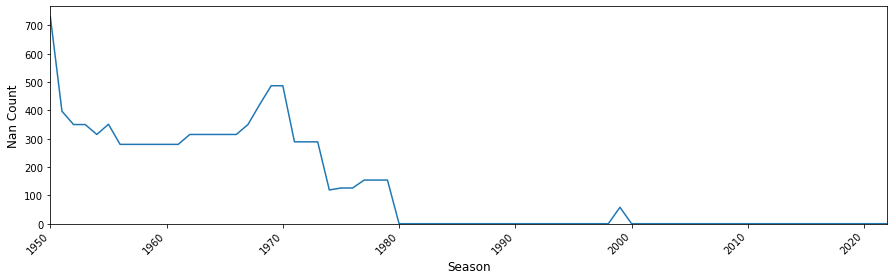

In [26]:
df_detail_nan = []

for season in df['season'].unique():
    df_nan = df[df['season'] == season]
    series_nan = df_nan.isnull().sum()
    df_nan = series_nan.to_frame(name="Nan_Count")
    df_nan = df_nan.rename_axis('Col_Name').reset_index()
    df_nan['season'] = season
    df_detail_nan.append(df_nan)

df_detail_nan = pd.concat(df_detail_nan, ignore_index=True)

df_per_season_nan = df_detail_nan[['season','Nan_Count']].groupby("season").sum().reset_index()
df_per_season_nan = df_per_season_nan.sort_values(by=['season'], ascending=True)

fig = plt.figure(figsize = (15, 4))
sns.lineplot(data=df_per_season_nan, x="season", y="Nan_Count", sort=True)
plt.ylim(0)
plt.ylabel('Nan Count', fontsize=12)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light', fontsize=10)
plt.xlabel('Season', fontsize=12)
plt.margins(x=0)
plt.show()

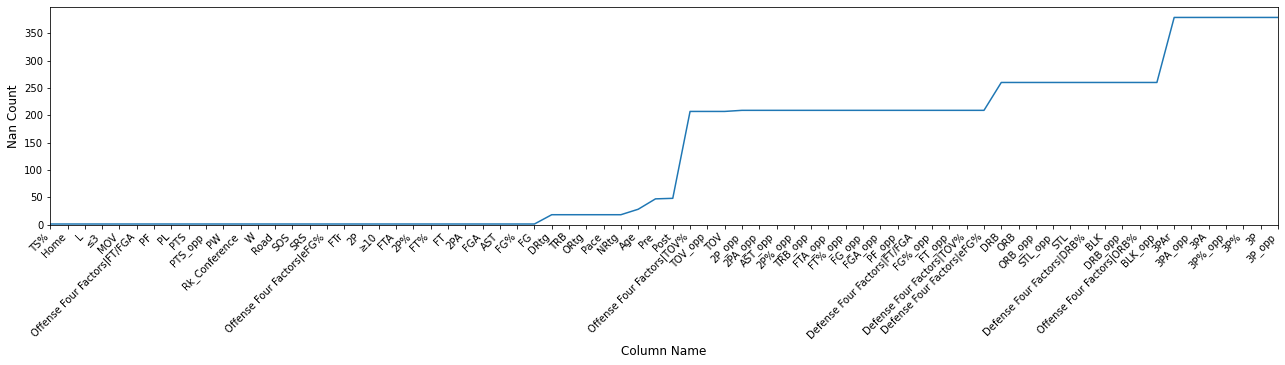

In [27]:
df_per_season_nan = df_detail_nan[['Col_Name','Nan_Count']].groupby("Col_Name").sum().reset_index()
df_per_season_nan = df_per_season_nan.sort_values(by=['Nan_Count'], ascending=True)
df_per_season_nan = df_per_season_nan[df_per_season_nan['Nan_Count'] > 0]

fig = plt.figure(figsize = (22, 4))
sns.lineplot(data=df_per_season_nan, x="Col_Name", y="Nan_Count")
plt.ylim(0)
plt.ylabel('Nan Count', fontsize=12)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light', fontsize=10)
plt.xlabel('Column Name', fontsize=12)
plt.margins(x=0)
plt.show()

### ➤ 3 Analyze Champion Data 
#### ➤ Results -> most nan values occur before 1980 season -> remove seasons before 1980
- The 3 point shot was introduced 1979-1980 (= 1980)
- Some stats, especially advanced stats, were not tracked back then

In [28]:
YEAR_3P = 1980

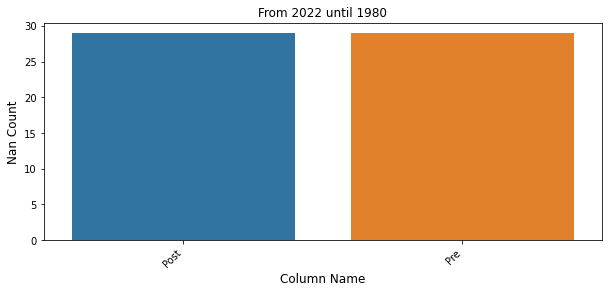

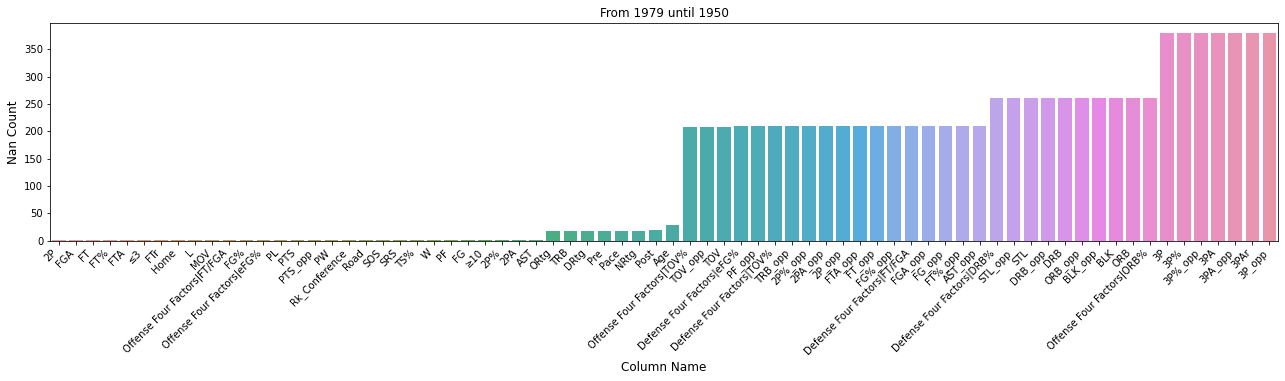

In [29]:
df_per_season_nan_new_era = df_detail_nan[(df_detail_nan['season'] >= YEAR_3P) & (df_detail_nan['Nan_Count'] > 0)]
df_per_season_nan_new_era = df_per_season_nan_new_era[['Col_Name','Nan_Count']].groupby("Col_Name").sum().reset_index()
df_per_season_nan_new_era = df_per_season_nan_new_era.sort_values(by=['Nan_Count'], ascending=True)

df_per_season_nan_old_era = df_detail_nan[(df_detail_nan['season'] < YEAR_3P) & (df_detail_nan['Nan_Count'] > 0)]
df_per_season_nan_old_era = df_per_season_nan_old_era[['Col_Name','Nan_Count']].groupby("Col_Name").sum().reset_index()
df_per_season_nan_old_era = df_per_season_nan_old_era.sort_values(by=['Nan_Count'], ascending=True)

fig = plt.figure(figsize = (10, 4))
sns.barplot(data=df_per_season_nan_new_era, x="Col_Name", y="Nan_Count")
plt.ylabel('Nan Count', fontsize=12)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light', fontsize=10)
plt.xlabel('Column Name', fontsize=12)
plt.title(f"From {df_detail_nan['season'].iloc[0]} until {YEAR_3P}", fontsize=12)
plt.show()

fig = plt.figure(figsize = (22, 4))
sns.barplot(data=df_per_season_nan_old_era, x="Col_Name", y="Nan_Count")
plt.ylabel('Nan Count', fontsize=12)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light', fontsize=10)
plt.xlabel('Column Name', fontsize=12)
plt.title(f"From {YEAR_3P-1} until {df_detail_nan['season'].iloc[-1]}", fontsize=12)
plt.show()

### ➤ 4 Machine Learning Process 

In [47]:
df = pd.read_csv("champ_data_edit.csv", encoding="utf-8-sig")
df

,season,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,...,L6YP,L10YP,count_playoff_games,count_champion,sum_mvp_shares,sum_dpoy_shares,count_all_nba,count_all_defensive,Rk_Conference,Top_3_Conference
0,2022,39.3,85.1,0.461,13.1,37.4,0.350,26.2,47.8,0.548,...,0.3750,0.6250,159.0,0.0,0.240,0.0,2.0,0.0,4.0,False
1,2022,39.4,86.4,0.456,13.5,38.7,0.349,25.9,47.7,0.543,...,1.8125,2.6250,0.0,0.0,0.000,0.0,0.0,0.0,15.0,False
2,2022,40.6,91.3,0.445,11.9,34.2,0.349,28.7,57.1,0.503,...,2.5625,2.7500,194.0,3.0,0.017,0.0,1.0,0.0,5.0,False
3,2022,40.2,88.0,0.457,10.6,32.1,0.332,29.5,55.9,0.528,...,0.3125,0.3125,155.0,0.0,0.000,0.0,0.0,0.0,9.0,False
4,2022,40.6,86.0,0.472,10.5,30.6,0.342,30.1,55.4,0.543,...,0.6250,1.3750,0.0,0.0,0.000,0.0,0.0,0.0,12.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,1950,31.5,85.8,0.367,NaN,NaN,NaN,31.5,85.8,0.367,...,0.0000,0.0000,0.0,0.0,0.000,0.0,0.0,0.0,1.0,True
1569,1950,29.2,82.4,0.354,NaN,NaN,NaN,29.2,82.4,0.354,...,0.0000,0.0000,0.0,0.0,0.000,0.0,0.0,0.0,3.0,True
1570,1950,31.0,82.5,0.375,NaN,NaN,NaN,31.0,82.5,0.375,...,0.0000,0.0000,0.0,0.0,0.000,0.0,0.0,0.0,1.0,True
1571,1950,30.4,97.7,0.311,NaN,NaN,NaN,30.4,97.7,0.311,...,0.0000,0.0000,0.0,0.0,0.000,0.0,0.0,0.0,2.0,True


In [48]:
try_col = ['W', 'L', 'PW', 'PL', 'Pre', 'Post', 'Playoff', 'Rk_Season', 'Overall', 'Rk_Conference', 'Home', 'Road', 'First_4_Months', 'Last_4_Months', 'Champion_Percent']
df.drop(try_col, axis="columns", inplace=True)
df = df[df['season'] >= YEAR_3P]
df.sort_values(by=['season'], ascending=False, inplace=True)

df_last = df[df['season'] > (MAX_SEASON - LAST_N_SEASONS)] 
df = df[df['season'] <= (MAX_SEASON - LAST_N_SEASONS)]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
all_seasons = np.arange(YEAR_3P, (MAX_SEASON - LAST_N_SEASONS) + 1, 1)
random.shuffle(all_seasons)

split_idx = round(all_seasons.shape[0] * 0.8)
train_seasons = all_seasons[:split_idx] 
test_seasons = all_seasons[split_idx:]

df_train = df[df['season'].isin(train_seasons)]
df_test = df[df['season'].isin(test_seasons)]

extra_col = ['name', 'season', 'Champion_Win_Share']
df_train_extra = df_train[extra_col]
df_test_extra = df_test[extra_col]
df_last_extra = df_last[extra_col]

train_labels = df_train_extra['Champion_Win_Share'].values
test_labels = df_test_extra['Champion_Win_Share'].values

for col in extra_col:
    del df_train[col]
    del df_test[col]
    del df_last[col]

In [54]:
numeric_col = [col for col in df_train.columns if col not in ["Top_3_Conference"]]
numeric_pipe = Pipeline(steps=[('imp_median', SimpleImputer(missing_values=np.nan, strategy='median')),
                               ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(sparse=False), ['Top_3_Conference']),
                                               ('num', numeric_pipe, numeric_col)])

train_features = preprocessor.fit_transform(df_train)
test_features = preprocessor.transform(df_test)
last_features = preprocessor.transform(df_last)

# Constructing header names manually
numeric_features = [col for col in df_train.columns if col not in ["Top_3_Conference"]]
categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out()

# The numeric features names remain unchanged since SimpleImputer and StandardScaler do not alter the feature names
header_names = list(categorical_features) + numeric_features

# header_names = [col.split("__")[1] for col in preprocessor.get_feature_names_out()]

In [55]:
df_test_extra.reset_index(drop=True, inplace=True)
df_test = pd.concat([pd.DataFrame(data=test_features, columns=header_names), df_test_extra], axis=1)

df_last_extra.reset_index(drop=True, inplace=True)
df_last = pd.concat([pd.DataFrame(data=last_features, columns=header_names), df_last_extra], axis=1)

In [56]:
def fit_and_evaluate(clf, param) -> list:
    clf.set_params(**param)
    clf.fit(train_features, train_labels)
                            
    test_predict = clf.predict(test_features)
    r2 = r2_score(test_labels, test_predict)
    mae = mean_absolute_error(test_labels, test_predict)
    mse = mean_squared_error(test_labels, test_predict)
    rmse = mean_squared_error(test_labels, test_predict, squared=False)
    
    ndcg = []
    for season in df_test['season'].unique():
        df_ndcg = df_test[df_test['season'] == season].copy()
        df_ndcg.sort_values(by=['Champion_Win_Share'], ascending=False, inplace=True)
        test_labels_ndcg = df_ndcg.pop('Champion_Win_Share')
        del df_ndcg['name']
        del df_ndcg['season']
        
        test_features_ndcg = df_ndcg.to_numpy()
        test_predict_ndcg = clf.predict(test_features_ndcg)
        
        ndcg_score_ = ndcg_score(y_true=[test_labels_ndcg], y_score=[test_predict_ndcg], k=5) 
        ndcg.append(ndcg_score_)                
        
    return [clf.__class__.__name__, r2, mae, mse, rmse, np.mean(ndcg), param.keys(), param.values()]

In [57]:
list_grid = []


clf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-3)
print(clf.__class__.__name__)
for max_depth in np.arange(3, 16, 1):
        sys.stdout.write(f"\rmax_depth: {max_depth}/15...")
        for n_estimators in np.arange(5, 20, 1):
                param = {"max_depth": max_depth,
                        "n_estimators": n_estimators}
                list_grid.append(fit_and_evaluate(clf, param))

                
clf = XGBRegressor(random_state=RANDOM_SEED, n_jobs=-3, verbosity=0)
print(clf.__class__.__name__)
for max_depth in np.arange(3, 11, 1):
        sys.stdout.write(f"\rmax_depth: {max_depth}/10...")
        for n_estimators in [10, 20, 50, 100]:
                for learning_rate in [0.1, 0.2, 0.3]:
                        for subsample in np.arange(0.4, 1.01, 0.1):
                                for colsample_bytree in np.arange(0.4, 1.01, 0.1): 
                                        param = {"max_depth": max_depth,
                                                "n_estimators": n_estimators,
                                                "learning_rate": learning_rate,
                                                "subsample": subsample, 
                                                "colsample_bytree": colsample_bytree}
                                        list_grid.append(fit_and_evaluate(clf, param))              

RandomForestRegressor
max_depth: 15/15...XGBRegressor
max_depth: 10/10...

In [58]:
df = pd.DataFrame(data=list_grid, columns=["clf", "R2", "MAE", "MSE", "RMSE", "NDCG", "param.keys", "param.values"], index=None)
df.sort_values(by=["NDCG"], ascending=False, inplace=True)
df[df['clf'] == "RandomForestRegressor"].head(10)

,clf,R2,MAE,MSE,RMSE,NDCG,param.keys,param.values
160,RandomForestRegressor,0.614852,0.104679,0.027722,0.166499,0.848372,"(max_depth, n_estimators)","(13, 15)"
28,RandomForestRegressor,0.671488,0.096777,0.023645,0.153771,0.847964,"(max_depth, n_estimators)","(4, 18)"
72,RandomForestRegressor,0.632448,0.100498,0.026455,0.162651,0.847792,"(max_depth, n_estimators)","(7, 17)"
70,RandomForestRegressor,0.631067,0.101278,0.026555,0.162957,0.845185,"(max_depth, n_estimators)","(7, 15)"
2,RandomForestRegressor,0.653705,0.101232,0.024925,0.157878,0.845011,"(max_depth, n_estimators)","(3, 7)"
146,RandomForestRegressor,0.612469,0.105034,0.027893,0.167013,0.845004,"(max_depth, n_estimators)","(12, 16)"
131,RandomForestRegressor,0.616283,0.104505,0.027619,0.166189,0.844269,"(max_depth, n_estimators)","(11, 16)"
145,RandomForestRegressor,0.604375,0.105875,0.028476,0.168749,0.842951,"(max_depth, n_estimators)","(12, 15)"
4,RandomForestRegressor,0.661277,0.099011,0.024380,0.156142,0.841756,"(max_depth, n_estimators)","(3, 9)"
56,RandomForestRegressor,0.631310,0.101002,0.026537,0.162903,0.841287,"(max_depth, n_estimators)","(6, 16)"


In [59]:
df[df['clf'] == "XGBRegressor"].head(10)

,clf,R2,MAE,MSE,RMSE,NDCG,param.keys,param.values
4564,XGBRegressor,0.669674,0.103107,0.023776,0.154195,0.912371,"(max_depth, n_estimators, learning_rate, subsa...","(10, 20, 0.3, 0.5, 0.5)"
1011,XGBRegressor,0.658677,0.103795,0.024568,0.156740,0.910648,"(max_depth, n_estimators, learning_rate, subsa...","(4, 20, 0.2, 0.7999999999999999, 0.79999999999..."
4858,XGBRegressor,0.640802,0.107988,0.025854,0.160792,0.908727,"(max_depth, n_estimators, learning_rate, subsa...","(10, 100, 0.3, 0.5, 0.5)"
4711,XGBRegressor,0.643130,0.107494,0.025687,0.160270,0.908727,"(max_depth, n_estimators, learning_rate, subsa...","(10, 50, 0.3, 0.5, 0.5)"
3277,XGBRegressor,0.661857,0.098771,0.024339,0.156009,0.905959,"(max_depth, n_estimators, learning_rate, subsa...","(8, 10, 0.3, 0.9999999999999999, 0.6)"
3571,XGBRegressor,0.660679,0.097541,0.024423,0.156280,0.904869,"(max_depth, n_estimators, learning_rate, subsa...","(8, 50, 0.3, 0.9999999999999999, 0.6)"
3424,XGBRegressor,0.662849,0.097056,0.024267,0.155779,0.904869,"(max_depth, n_estimators, learning_rate, subsa...","(8, 20, 0.3, 0.9999999999999999, 0.6)"
3718,XGBRegressor,0.660610,0.097573,0.024428,0.156296,0.904869,"(max_depth, n_estimators, learning_rate, subsa...","(8, 100, 0.3, 0.9999999999999999, 0.6)"
2281,XGBRegressor,0.648948,0.104003,0.025268,0.158959,0.900139,"(max_depth, n_estimators, learning_rate, subsa...","(6, 50, 0.1, 0.7999999999999999, 0.4)"
2287,XGBRegressor,0.675485,0.097297,0.023358,0.152832,0.899786,"(max_depth, n_estimators, learning_rate, subsa...","(6, 50, 0.1, 0.7999999999999999, 0.99999999999..."


In [60]:
clf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-3, max_depth=4, n_estimators=14)
clf.fit(train_features, train_labels) 

df_n_victory_list = []
ndcg = [] 
for season_n in df_last['season'].unique():
        df_n = df_last[df_last['season'] == season_n].copy()
        names_n = df_n["name"].values
        df_n.drop(['season', 'name'], axis="columns", inplace=True)
        y_true = df_n.pop('Champion_Win_Share')
        feature_n = df_n.to_numpy()
        del df_n

        prediction = clf.predict(feature_n)
        ndcg_score_ = ndcg_score(y_true=[y_true], y_score=[prediction], k=5) 
        ndcg.append(ndcg_score_)
        
        df_n_victory = pd.DataFrame(data=feature_n, index=None, columns=header_names)
        df_n_victory['season'] = season_n
        df_n_victory['Teams'] = names_n
        df_n_victory['Champion_Shares_in_%'] = prediction * 100
        df_n_victory.sort_values(by=['Champion_Shares_in_%'], ascending=False, ignore_index=True, inplace=True)
        df_n_victory_list.append(df_n_victory)
        
        print(season_n)
        print(df_n_victory[['Teams', 'Champion_Shares_in_%']].head(5))
        print("=============================================================================")
        print("============================================================================\n")

print("NDCG-Score:", np.mean(ndcg))
df_n_victory_list = pd.concat(df_n_victory_list, ignore_index=True)
df_n_victory_list.to_csv("champ_predict.csv", index=False, encoding="utf-8-sig")

2022
                   Teams  Champion_Shares_in_%
0  Golden State Warriors             71.674365
1           Phoenix Suns             67.231465
2             Miami Heat             64.454320
3         Boston Celtics             63.677364
4        Milwaukee Bucks             50.488410

2021
                Teams  Champion_Shares_in_%
0  Philadelphia 76ers             59.387045
1           Utah Jazz             59.248751
2      Denver Nuggets             57.015627
3       Brooklyn Nets             54.118260
4     Milwaukee Bucks             52.719262

2020
                  Teams  Champion_Shares_in_%
0       Toronto Raptors             69.348946
1        Boston Celtics             65.325731
2    Los Angeles Lakers             62.010707
3  Los Angeles Clippers             61.754703
4       Milwaukee Bucks             59.248751

NDCG-Score: 0.7521731574565389


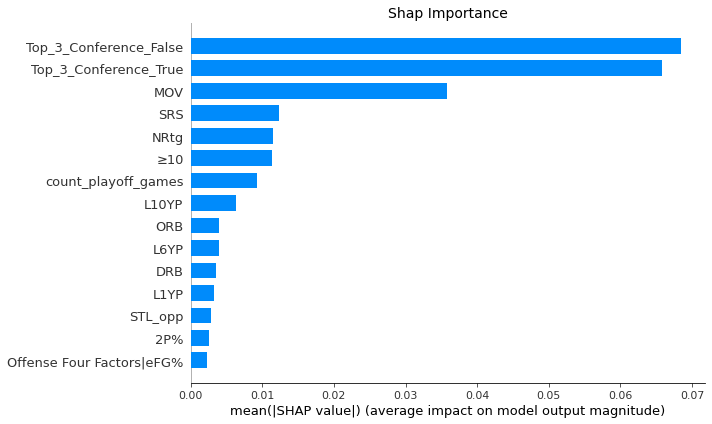

In [61]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(test_features)

shap.summary_plot(shap_values, test_features, plot_type="bar", feature_names=header_names, 
                    show=False, max_display=15, class_inds="original")
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.title("Shap Importance", fontsize=14, loc="center")   
plt.tight_layout()
fig.savefig("pngs/shap_importance.png")
plt.show() 

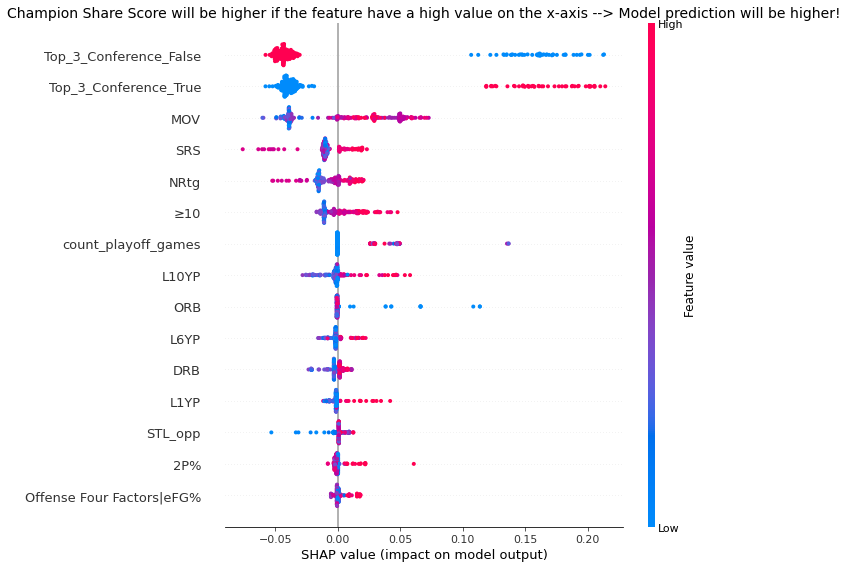

In [62]:
title = "Champion Share Score will be higher if the feature have a high value on the x-axis --> Model prediction will be higher!"
shap.summary_plot(shap_values, test_features, feature_names=header_names, show=False, max_display=15, plot_type="dot")
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.title(title, fontsize=14, loc="center")   
plt.tight_layout()
fig.savefig("pngs/fi_impact.png")

![](pngs/fi_impact_edit.png)

### ➤ 5 PowerBi Charts

### ➤ 2022
![](pngs/nba_heat_table_2022.PNG)
<br><br>
![](pngs/nba_compare_2022.PNG)

---

### ➤ 2021
![](pngs/nba_heat_table_2021.PNG)
<br><br>
![](pngs/nba_compare_2021.PNG)

---

### ➤ 2020
![](pngs/nba_heat_table_2020.PNG)
<br><br>
![](pngs/nba_compare_2020.PNG)

---